In [23]:
# importing data processing tools: pandas and numpy
import numpy as np
import pandas as pd
from pandas import Series, DataFrame

#Classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
#Regressors
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_squared_log_error as msle

from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve

from sklearn.model_selection import GridSearchCV
import time
import warnings
warnings.filterwarnings('ignore')

In [24]:
bc = pd.read_csv('/content/mushroom(C)_withoutNANs.csv')

In [25]:
bc.head()

,Unnamed: 0,target,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,0,e,x,s,y,t,a,f,c,b,...,s,w,w,p,w,o,p,n,n,g
1,1,e,b,s,w,t,l,f,c,b,...,s,w,w,p,w,o,p,n,n,m
2,2,p,x,y,w,t,p,f,c,n,...,s,w,w,p,w,o,p,k,s,u
3,3,e,x,s,g,f,n,f,w,b,...,s,w,w,p,w,o,e,n,a,g
4,4,e,x,y,y,t,a,f,c,b,...,s,w,w,p,w,o,p,k,n,g


In [28]:
# Function for classifier problem
# using metric: accuracy
# ds - dataset, target - target feature title from the dataset, may not be set
def classif_func(ds, target):
  rn_st = 20
  
  titles = ['DecisionTreeClassifier',
          'RandomForestClassifier',
          'LogisticRegression',
          'XGBClassifier']

  cls = [DecisionTreeClassifier(random_state = rn_st),
       RandomForestClassifier(random_state = rn_st),
       LogisticRegression(random_state = rn_st),
       XGBClassifier(random_state = rn_st, n_jobs = -1)]

  scalers = [StandardScaler(),
           MinMaxScaler()]     
  
 #For GridSearchCV
  par_gcv = {'n_estimators': [5, 10, 30, 75],
           'max_depth': [5, 15, 50, 100],
           'max_features': [2, 5, 7, 10]}   
  #Scores
  train_score = []
  val_score = []
  test_score = []

  if 'target' in ds.columns:
    y = ds['target']
    X = ds.drop('target', axis = 1)
  else:
    y = ds[target]
    X = ds.drop(target, axis = 1)
  
  encoder = preprocessing.LabelEncoder()
  y = encoder.fit_transform(y)
  X = pd.get_dummies(X, columns = X.columns, drop_first = True)
  
    #Train-test split
  X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = 0.25, random_state = rn_st)
  X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.25, random_state = rn_st)
  X = StandardScaler().fit(X_train)

  for clf, ttl in zip(cls, titles):
    #Get model hyperparameters to perform GridSearchCV properly
    params = clf.get_params()

    #Intersection keys for GridSearchCV
    keys = params.keys() & par_gcv.keys()
    if keys:
      #New intersection set
      set_isc = {}
      for key in keys:
        set_isc[key] = par_gcv[key]
        gcv = GridSearchCV(clf, set_isc, scoring = 'accuracy', cv = 3, n_jobs = -1)
        gcv.fit(X_train, y_train)
      print('\n', ttl, ' optimal with ', gcv.best_params_)
    #refit
      gcv.best_estimator_.fit(X_train, y_train)
    
    #feature importances
    #Do if-else because there is no 'feature_importances_' attribute in LogReg
      if (ttl == 'LogisticRegression'):
        fimp = pd.Series(gcv.best_estimator_.coef_[0], index = X_train.columns)
        print('\n The most important features of ' + ttl + ' are: ')
        print(fimp.nlargest(10))
      else:
        fimp = pd.Series(gcv.best_estimator_.feature_importances_, index = X_train.columns)
        print('\n The most important features of ' + ttl + ' are: ')
        print(fimp.nlargest(10))
      fimp.nlargest(10).sort_values(ascending = True).plot.barh(figsize = (10, 7), title = ttl)
      plt.show()
    #scores
      train_score.append(np.round(accuracy_score(y_train, gcv.best_estimator_.predict(X_train)), 2))
      val_score.append(np.round(accuracy_score(y_val, gcv.best_estimator_.predict(X_val)), 2))
      test_score.append(np.round(accuracy_score(y_test, gcv.best_estimator_.predict(X_test)), 2))
      

# If there is no intersection with par_gcv. We train a model as it is without using GridSearchCV
    else:
      clf.fit(X_train_val, y_train_val)
    #feature importances
      if (ttl == 'LogisticRegression'):
        fimp = pd.Series(clf.coef_[0], index = X_train.columns)
        print('\n The most important features of ' + ttl + ' are: ')
        print(fimp.nlargest(10))
      else:
        fimp = pd.Series(clf.feature_importances_, index = X_train.columns)
        print('\n The most important features of ' + ttl + ' are: ')
        print(fimp.nlargest(10))
      fimp.nlargest(10).sort_values(ascending = True).plot.barh(figsize = (10, 7), title = ttl)
      plt.show()
    #scores
      train_score.append(np.round(clf.score(X_train_val, y_train_val), 2))
      val_score.append(np.round(clf.score(X_val, y_val), 2))
      test_score.append(np.round(clf.score(X_test, y_test), 2))
    #output      
  return pd.DataFrame({'Classifiers': titles,
                         'Train score': train_score,
                         'Validation score': val_score,
                         'Test score': test_score})

DecisionTreeClassifier  optimal with  {'max_depth': 100, 'max_features': 7}

 The most important features of DecisionTreeClassifier are: 
odor_n                        0.113671
stalk-surface-above-ring_s    0.081324
ring-type_p                   0.074700
stalk-color-below-ring_g      0.068654
stalk-color-above-ring_w      0.068407
odor_f                        0.039128
ring-type_l                   0.032975
cap-color_e                   0.032796
gill-size_n                   0.031993
stalk-shape_t                 0.026744
dtype: float64


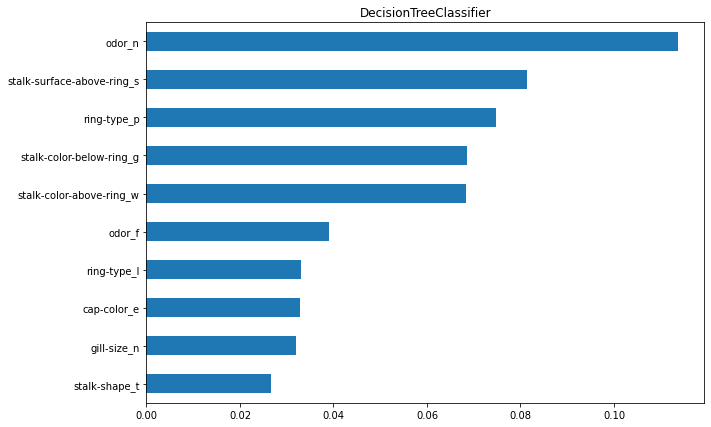

RandomForestClassifier  optimal with  {'max_depth': 100, 'max_features': 5, 'n_estimators': 75}

 The most important features of RandomForestClassifier are: 
stalk-surface-above-ring_k    0.077199
odor_n                        0.068865
stalk-surface-below-ring_k    0.045681
stalk-shape_t                 0.039793
ring-type_l                   0.036422
odor_f                        0.031781
bruises_t                     0.031050
stalk-color-above-ring_w      0.027115
stalk-surface-above-ring_s    0.025529
gill-size_n                   0.025425
dtype: float64


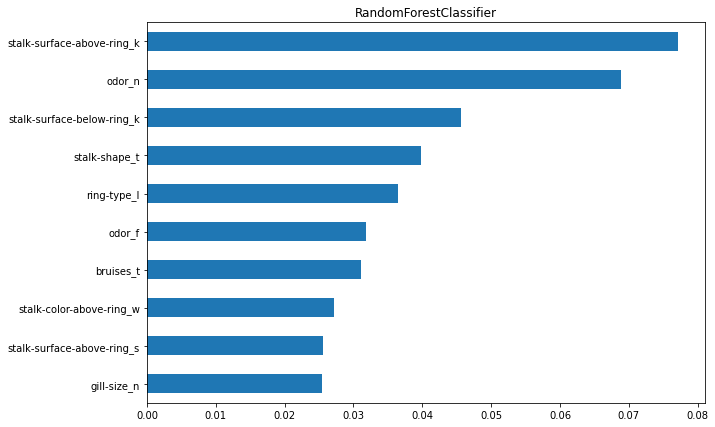

odor_f                        3.950315
odor_p                        3.313258
odor_c                        3.283662
spore-print-color_r           2.569306
population_c                  2.420368
gill-size_n                   2.016021
stalk-surface-above-ring_k    1.272658
stalk-surface-below-ring_k    0.954800
ring-type_l                   0.954800
cap-surface_s                 0.881931
dtype: float64


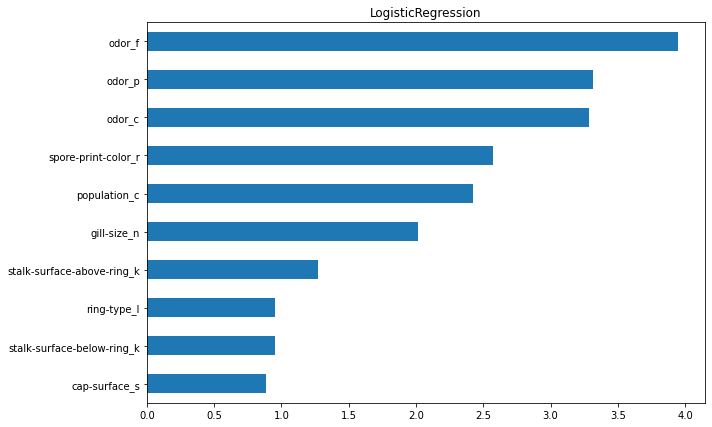

XGBClassifier  optimal with  {'max_depth': 5, 'n_estimators': 5}

 The most important features of XGBClassifier are: 
odor_f                 0.631841
gill-size_n            0.172546
stalk-shape_t          0.059451
spore-print-color_r    0.054684
odor_n                 0.051407
odor_m                 0.022140
population_c           0.007932
Unnamed: 0_1           0.000000
Unnamed: 0_2           0.000000
Unnamed: 0_3           0.000000
dtype: float32


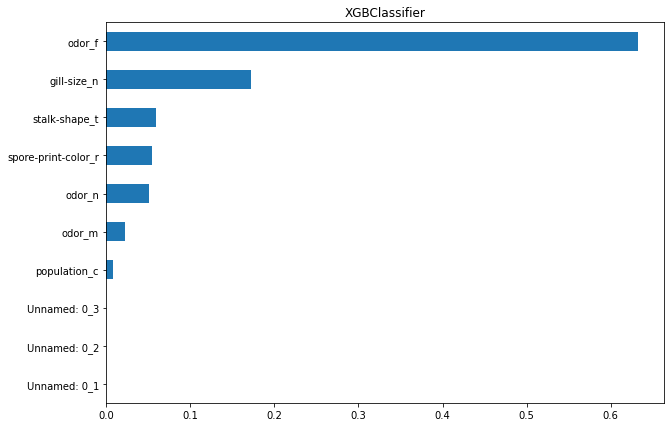

,Classifiers,Train score,Validation score,Test score
0,DecisionTreeClassifier,0.99,0.98,0.98
1,RandomForestClassifier,1.00,1.00,1.00
2,LogisticRegression,1.00,1.00,1.00
3,XGBClassifier,1.00,1.00,1.00


In [29]:
classif_func(bc, target = ' ')

In [30]:
reg = RandomForestRegressor()
params = reg.get_params()
print(params)
if 'n_jobs' in params:
      print(True)

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
True


In [31]:
br = pd.read_csv('/content/bias_correction_temp_forecast(R)_withoutNANs.csv')

In [32]:
br.head()

,station,Date,Present_Tmax,Present_Tmin,LDAPS_RHmin,LDAPS_RHmax,LDAPS_Tmax_lapse,LDAPS_Tmin_lapse,LDAPS_WS,LDAPS_LH,...,LDAPS_PPT2,LDAPS_PPT3,LDAPS_PPT4,lat,lon,DEM,Slope,Solar radiation,Next_Tmax,Next_Tmin
0,1.0,2013-06-30,28.7,21.4,58.255688,91.116364,28.074101,23.006936,6.818887,69.451805,...,0.0,0.0,0.0,37.6046,126.991,212.3350,2.7850,5992.895996,29.1,21.2
1,2.0,2013-06-30,31.9,21.6,52.263397,90.604721,29.850689,24.035009,5.691890,51.937448,...,0.0,0.0,0.0,37.6046,127.032,44.7624,0.5141,5869.312500,30.5,22.5
2,3.0,2013-06-30,31.6,23.3,48.690479,83.973587,30.091292,24.565633,6.138224,20.573050,...,0.0,0.0,0.0,37.5776,127.058,33.3068,0.2661,5863.555664,31.1,23.9
3,4.0,2013-06-30,32.0,23.4,58.239788,96.483688,29.704629,23.326177,5.650050,65.727144,...,0.0,0.0,0.0,37.6450,127.022,45.7160,2.5348,5856.964844,31.7,24.3
4,5.0,2013-06-30,31.4,21.9,56.174095,90.155128,29.113934,23.486480,5.735004,107.965535,...,0.0,0.0,0.0,37.5507,127.135,35.0380,0.5055,5859.552246,31.2,22.5


In [37]:
# Function for regressor problem
# using metric: MSE
# ds - dataset, target - target feature title from the dataset, may not be set
def reg_func(ds, target):
  rn_st = 20
  
  titles = ['DecisionTreeRegressor',
          'RandomForestRegressor',
          'LinearRegressor',
          'XGBRegressor']

  regs = [DecisionTreeRegressor(random_state = rn_st),
       RandomForestRegressor(random_state = rn_st, n_jobs = -1),
       LinearRegression(n_jobs = -1),
       #n_jobs = -1 causes memory leak error :( 
       #The exit codes of the workers are {SIGKILL(-9)}
       XGBRegressor(n_jobs = 1, random_state = rn_st)]

  scalers = [StandardScaler(),
           MinMaxScaler()]     
  
 #For GridSearchCV
  par_gcv = {'n_estimators': [5, 10, 30, 75],
           'max_depth': [5, 15, 50, 100],
           'learning_rate': [0.05, 0.1, 0.5],
           'max_features': [2, 5, 7, 10]}   
  #Scores
  train_score = []
  val_score = []
  test_score = []

  if 'target' in ds.columns:
    y = ds['target']
    X = ds.drop('target', axis = 1)
  else:
    y = ds[target]
    X = ds.drop(target, axis = 1)
  
  encoder = preprocessing.LabelEncoder()
  y = encoder.fit_transform(y)
  X = pd.get_dummies(X, columns = X.columns, drop_first = True)
  
    #Train-test split
  X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = 0.25, random_state = rn_st)
  X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.25, random_state = rn_st)
  X = StandardScaler().fit(X_train)

  for reg, ttl in zip(regs, titles):
    #Get model hyperparameters to perform GridSearchCV properly
    params = reg.get_params()

    #Intersection keys for GridSearchCV
    keys = params.keys() & par_gcv.keys()
    if keys:
      #New intersection set
      set_isc = {}
      for key in keys:
        set_isc[key] = par_gcv[key]
        gcv = GridSearchCV(reg, set_isc, scoring = 'neg_mean_squared_error', cv = 3, n_jobs = -1)
        gcv.fit(X_train_val, y_train_val)
      print('\n', ttl, ' optimal with ', gcv.best_params_)
    #refit
      gcv.best_estimator_.fit(X_train, y_train)
    
    #feature importances
    #Do if-else because there is no 'feature_importances_' attribute in LogReg
      if (ttl == 'LinearRegressor'):
        fimp = pd.Series(gcv.best_estimator_.coef_[0], index = X_train.columns)
        print('\n The most important features of ' + ttl + ' are: ')
        print(fimp.nlargest(10))
      else:
        fimp = pd.Series(gcv.best_estimator_.feature_importances_, index = X_train.columns)
        print('\n The most important features of ' + ttl + ' are: ')
        print(fimp.nlargest(10))
      fimp.nlargest(10).sort_values(ascending = True).plot.barh(figsize = (10, 7), title = ttl)
      plt.show()
    #scores
      train_score.append(np.round(mse(y_train, gcv.best_estimator_.predict(X_train)), 2))
      val_score.append(np.round(mse(y_val, gcv.best_estimator_.predict(X_val)), 2))
      test_score.append(np.round(mse(y_test, gcv.best_estimator_.predict(X_test)), 2))
      

# If there is no intersection with par_gcv. We train a model as it is without using GridSearchCV
    else:
      reg.fit(X_train, y_train)
    #feature importances
      if (ttl == 'LinearRegressor'):
        fimp = pd.Series(reg.coef_, index = X_train.columns)
        print('\n The most important features of ' + ttl + ' are: ')
        print(fimp.nlargest(10))
      else:
        fimp = pd.Series(reg.feature_importances_, index = X_train.columns)
        print(fimp.nlargest(10))
      fimp.nlargest(10).sort_values(ascending = True).plot.barh(figsize = (10, 7), title = ttl)
      plt.show()
    #scores
      train_score.append(np.round(mse(y_train_val, reg.predict(X_train_val)), 2))
      val_score.append(np.round(mse(y_val, reg.predict(X_val)), 2))
      test_score.append(np.round(mse(y_test, reg.predict(X_test)), 2))
    #output      
  return pd.DataFrame({'Regressors': titles,
                         'Train score': train_score,
                         'Validation score': val_score,
                         'Test score': test_score})


 DecisionTreeRegressor  optimal with  {'max_depth': 100, 'max_features': 10}

 The most important features of DecisionTreeRegressor are: 
Present_Tmin_25.7          0.048194
Next_Tmin_20.5             0.040969
Next_Tmin_25.4             0.032853
Next_Tmin_18.9             0.028579
Next_Tmin_16.4             0.027653
LDAPS_CC2_0.894387977      0.025137
LDAPS_RHmax_89.29141998    0.019750
LDAPS_CC4_0.11899653       0.016646
LDAPS_RHmax_74.0994339     0.015906
LDAPS_CC2_0.648211078      0.014737
dtype: float64


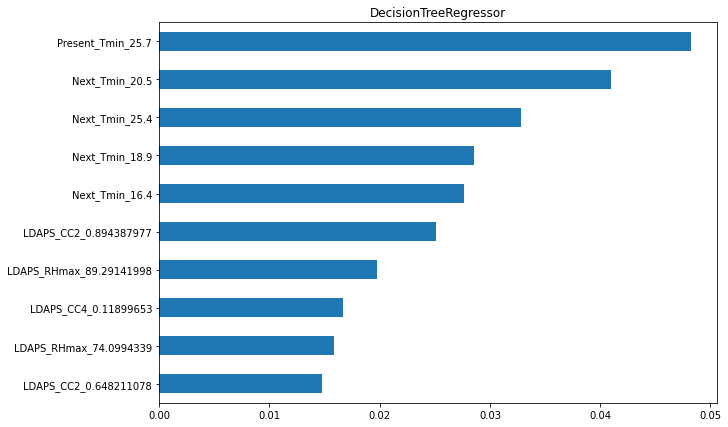


 RandomForestRegressor  optimal with  {'max_depth': 100, 'max_features': 10, 'n_estimators': 75}

 The most important features of RandomForestRegressor are: 
Next_Tmin_26.7       0.003251
lon_126.991          0.002839
lat_37.6046          0.002700
Date_2017-08-29      0.002579
Date_2016-07-04      0.002575
Present_Tmax_33.1    0.002556
DEM_212.335          0.002416
Date_2016-08-03      0.002266
Date_2016-08-27      0.002265
Date_2014-08-13      0.002120
dtype: float64


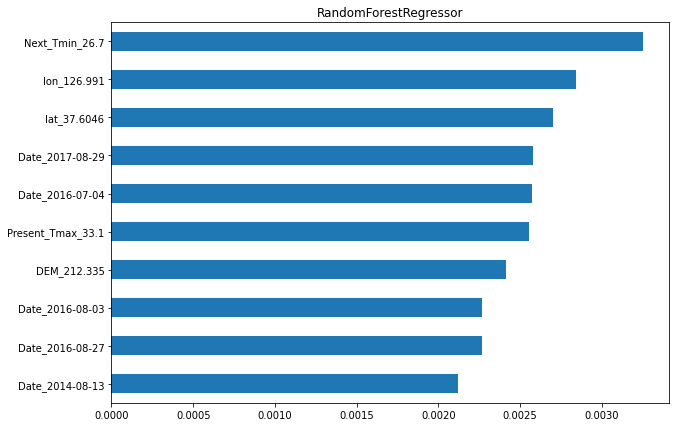

Date_2014-07-24    30.038384
Date_2014-07-06    26.093416
Date_2015-07-14    21.251085
Date_2016-08-03    20.706028
Date_2016-08-10    20.606878
Date_2017-07-24    20.501997
Date_2015-07-10    20.111819
Date_2017-08-04    19.448443
Date_2016-08-04    19.258071
Date_2016-07-18    19.076727
dtype: float64


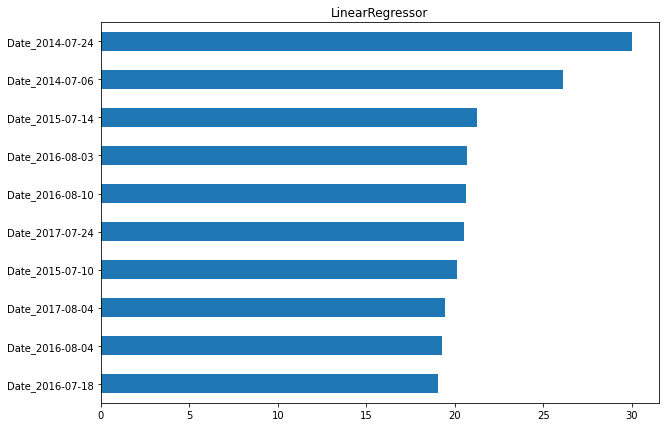

exception calling callback for <Future at 0x7f44383b5bd0 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "/usr/local/lib/python3.7/dist-packages/joblib/parallel.py", line 359, in __call__
    self.parallel.dispatch_next()
  File "/usr/local/lib/python3.7/dist-packages/joblib/parallel.py", line 794, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "/usr/local/lib/python3.7/dist-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/usr/local/lib/python3.7/dist-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/usr/local/lib/python3.7/dist-packages/joblib/_parallel_backends.py", line 531, in apply_async
    future = self._workers.submit(SafeFunction(func))
  File "/usr/local/lib/

TerminatedWorkerError: ignored

In [38]:
reg_func(br, 'Next_Tmax')